In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar

# Define the data
measurement_time = np.array([0.2666666667, 1.333333333, 2.666666667, 13.33333333, 26.66666667, 266.66666667])
peak_position_error = np.array([0.0522665, 0.022858, 0.0161813, 0.00710165, 0.00503183, 0.00160144])
def inv_sqrt(x, a, b):
    with np.errstate(invalid='ignore'):
        return a / np.sqrt(x + b)

# Test the fits and calculate errors
def test_fit(func, x, y):
    popt, _ = curve_fit(func, x, y)
    error = np.sum((y - func(x, *popt))**2)
    return popt, error

# Perform fit
params_inv_sqrt, error_inv_sqrt = test_fit(inv_sqrt, measurement_time, peak_position_error)

best_fit_func = inv_sqrt
best_fit_params = params_inv_sqrt

# Estimate the amount of measurement time needed to reach a peak position error
def find_measurement_time_for_target_error(func, params, target_error):
    def target_func(t):
        return func(t, *params) - target_error

    # Bracket adjustment
    lower_bound = min(measurement_time)
    upper_bound = lower_bound
    increment = 1000

    # Increase the upper bound until the target function changes sign
    while target_func(upper_bound) * target_func(lower_bound) > 0:
        upper_bound += increment
        if upper_bound > 1e6:  # Avoid infinite loop by setting an upper limit
            raise ValueError("Failed to find an appropriate upper bound for root finding")

    result = root_scalar(target_func, bracket=[lower_bound, upper_bound], method='brentq')
    return result.root

# Calculate required times
target_errors = [0.0004, 0.0005]
required_times_minutes = [find_measurement_time_for_target_error(best_fit_func, best_fit_params, target_error) for target_error in target_errors]
required_times_days = [time / 1440 for time in required_times_minutes]  # Convert from minutes to days (1 day = 1440 minutes)

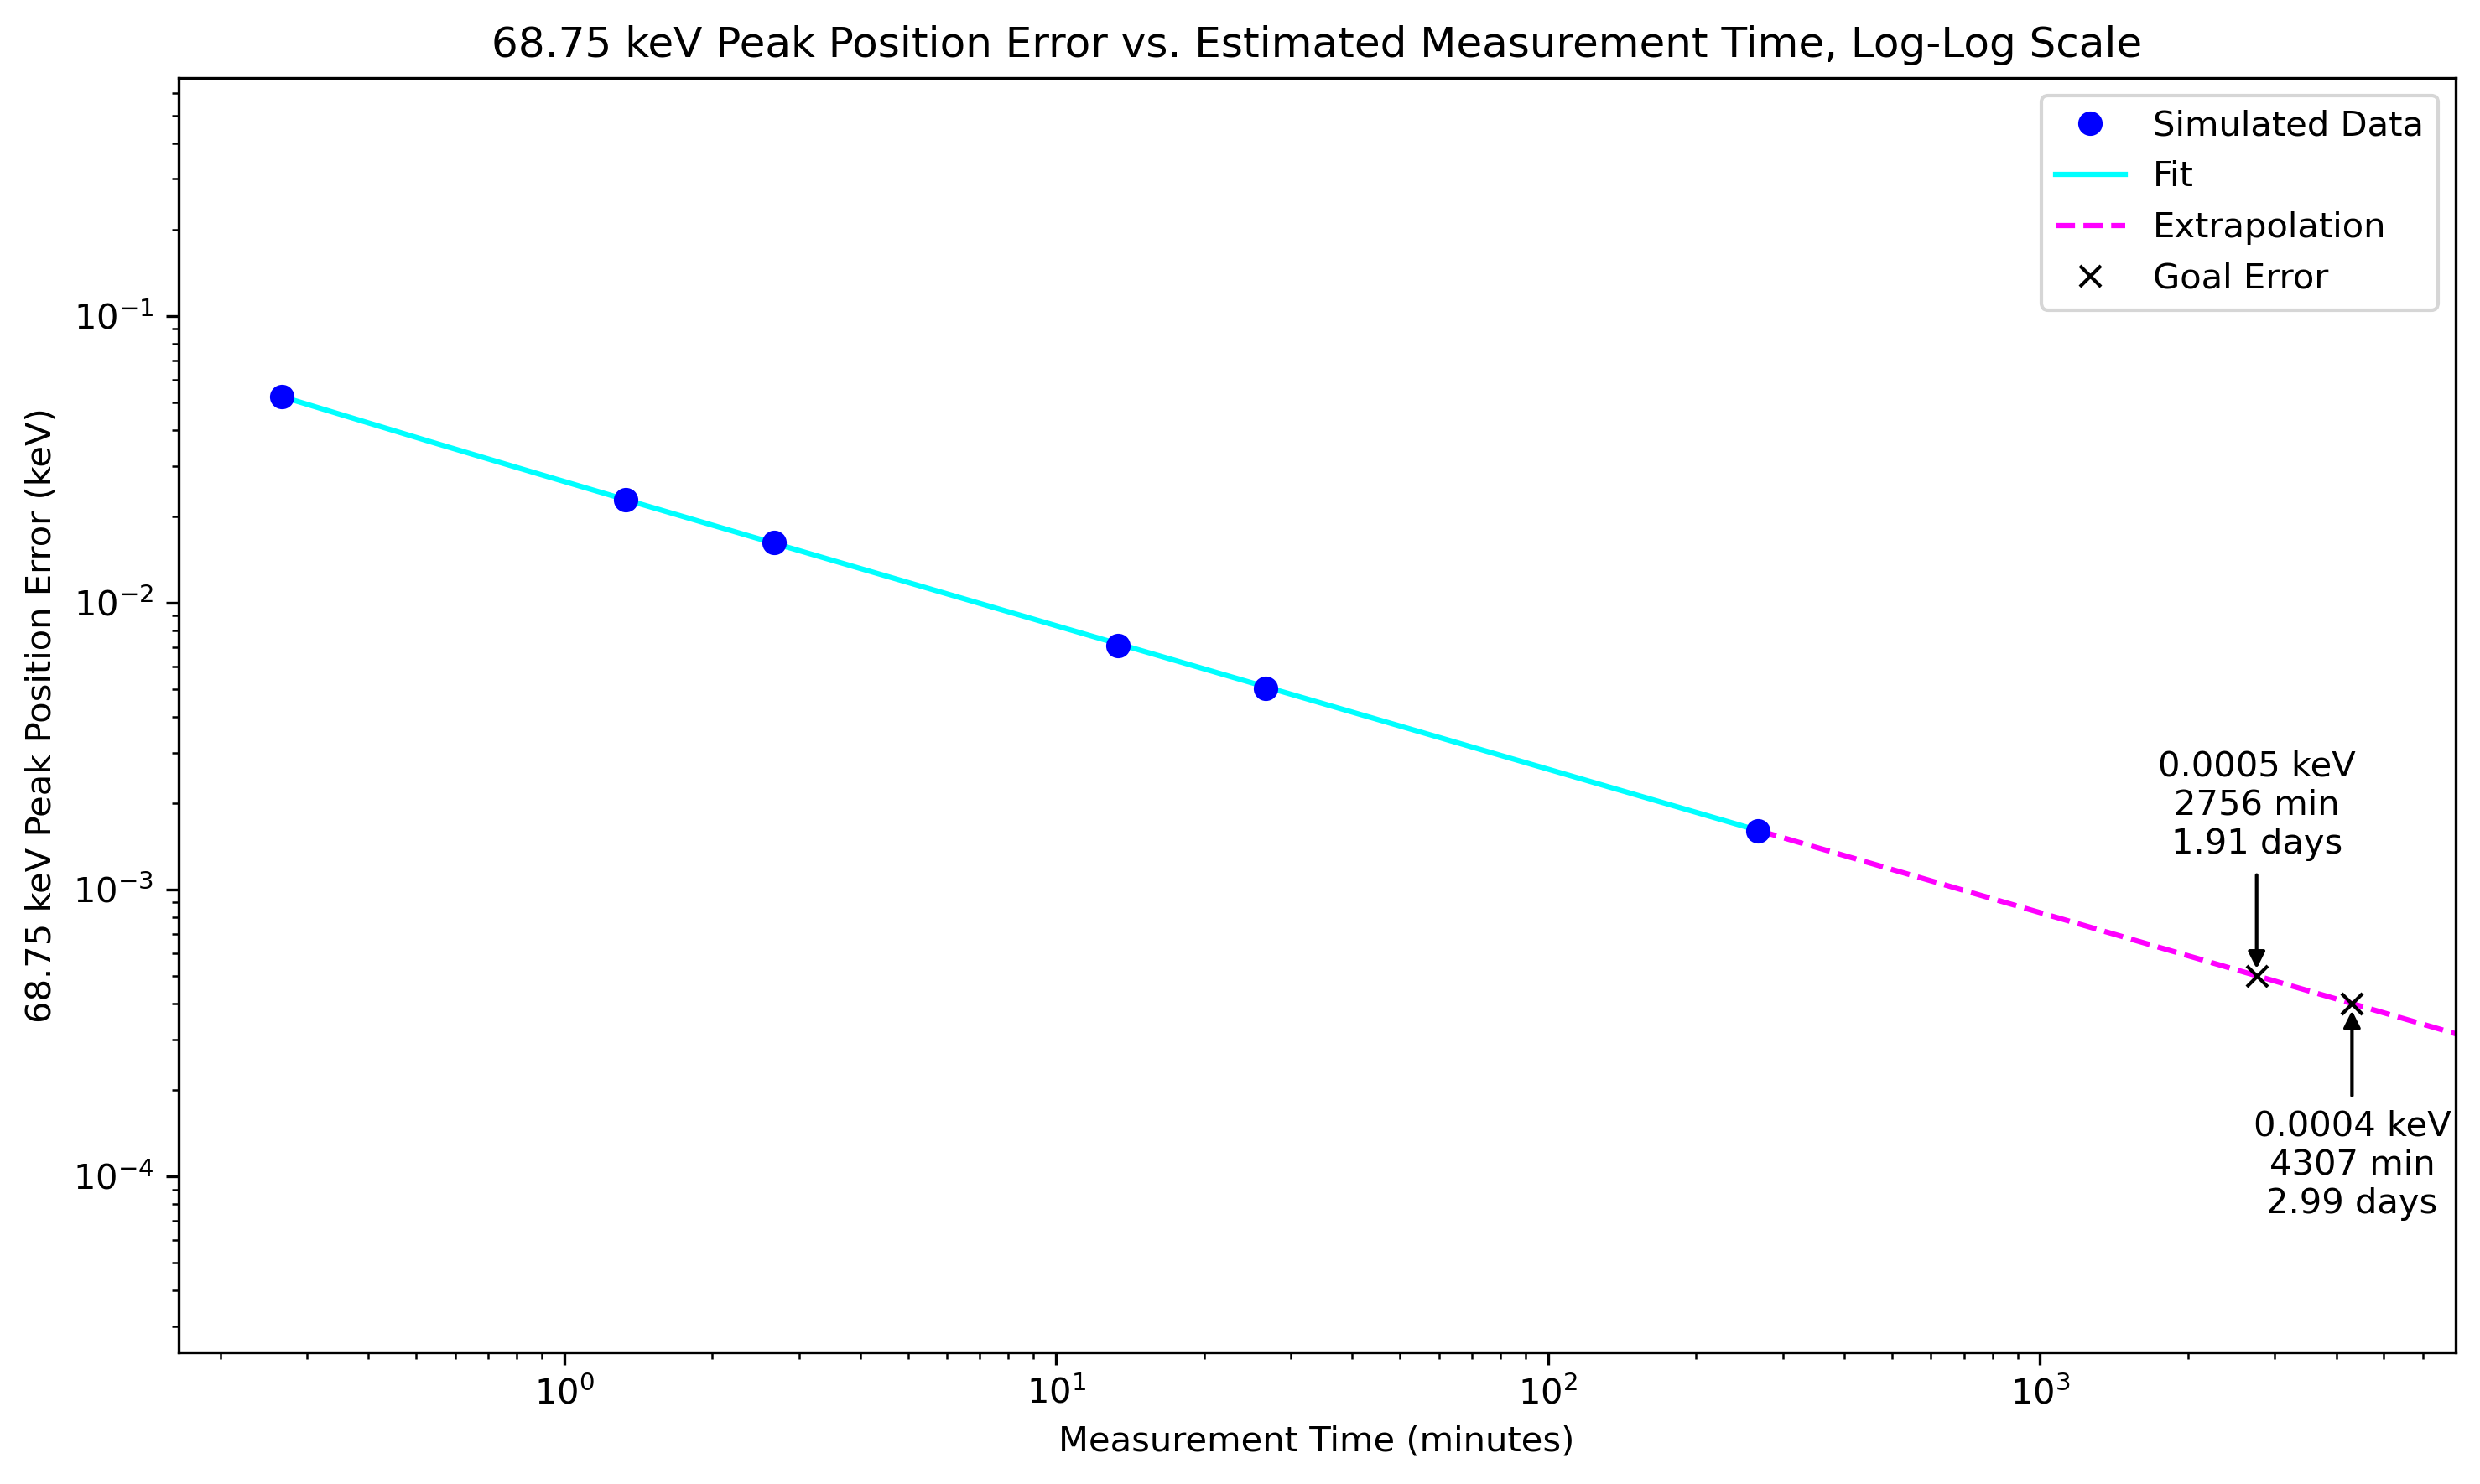

In [57]:
def plot_with_annotations(func, params, x, y, func_name, target_errors, required_times_minutes):
    x_fit = np.linspace(min(x), max(x), 1000)
    y_fit = func(x_fit, *params)
    x_extrap = np.linspace(max(x), 7000, 1000)
    y_extrap = func(x_extrap, *params)
    
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(x, y, 'o', label='Simulated Data', color=(0,0,1),zorder=2)
    plt.plot(x_fit, y_fit, '-', label='Fit', color=(0,1,1),zorder=1)
    plt.plot(x_extrap, y_extrap, '--', label='Extrapolation', color=(1,0,1),zorder=1)
    
    
    for target_error, req_time_min in zip(target_errors, required_times_minutes):
        x_coord = req_time_min
        y_coord = func(x_coord, *params)
        if target_error == 0.0004:
            plt.plot([x_coord], [y_coord], 'x', color='black', label='Goal Error')
            plt.annotate(f'{target_error} keV\n{x_coord:.0f} min\n{x_coord/1440:.2f} days',  # Convert minutes back to days
                         xy=(x_coord, y_coord), 
                         xycoords='data', 
                         textcoords='offset points',
                         xytext=(0, -60),  # Position text below the point
                         ha='center', 
                         fontsize=10, 
                         color='black', 
                         arrowprops=dict(facecolor='black', arrowstyle='-|>'))
        
        if target_error == 0.0005:
            plt.plot([x_coord], [y_coord], 'x', color='black')
            plt.annotate(f'{target_error} keV\n{x_coord:.0f} min\n{x_coord/1440:.2f} days',  # Convert minutes back to days
                         xy=(x_coord, y_coord), 
                         xycoords='data', 
                         textcoords='offset points',
                         xytext=(0, 35),  # Position text above the point
                         ha='center', 
                         fontsize=10, 
                         color='black', 
                         arrowprops=dict(facecolor='black', arrowstyle='-|>'))

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Measurement Time (minutes)')
    plt.ylabel('68.75 keV Peak Position Error (keV)')
    plt.legend()
    plt.title('68.75 keV Peak Position Error vs. Estimated Measurement Time, Log-Log Scale')

    y_min, y_max = plt.ylim()  # Get the current y-axis limits
    expanded_y_min = y_min * 0.1
    expanded_y_max = y_max * 10
    plt.ylim(expanded_y_min, expanded_y_max)  # Expand y limits
    
    lowx = 0.16427045453116118
    highx = 6991.38914540491
    plt.xlim(lowx, highx)
    
    plt.tight_layout()
    plt.savefig('proposal.png')
    plt.show()

# Save the best fit plot with annotations for required times
plot_with_annotations(best_fit_func, best_fit_params, measurement_time, peak_position_error, 'Best Fit', target_errors, required_times_minutes)
